<a href="https://colab.research.google.com/github/Febriant58/Tugas_Autoencoder_DeepLearning-A_3058/blob/main/Image_colorization_with_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aayush9753_image_colorization_dataset_path = kagglehub.dataset_download('aayush9753/image-colorization-dataset')

print('Data source import complete.')


Data source import complete.


# Image colorization menggunakan Autoencoders

In [2]:
# import required libraries
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential, Model
from skimage.color import rgb2lab, lab2rgb, rgb2gray

print(tf.__version__)

2.18.0


# 1. Data preparation

In [3]:
# create a generator and get the images from the directory
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
seed = 10
images_set = img_generator.flow_from_directory(
    '/kaggle/input/image-colorization-dataset/data/',
    seed=seed,
    batch_size=64,
)

Found 11478 images belonging to 4 classes.


Terdapat total **11.478** gambar dalam dataset ini. Sebanyak 5.000 gambar merupakan training set (X), 5.000 lainnya adalah training set (Y), dan sisanya merupakan validation set. Artinya, kita memiliki 5.000 gambar berwarna dan 5.000 dalam bentuk grayscale.

Namun, saya tidak akan menggunakan gambar grayscale dari dataset ini; sebagai gantinya, saya akan mengonversi gambar berwarna menjadi gambar grayscale karena cara tersebut lebih mudah untuk dikelola. Selain itu, kita hanya akan menggunakan 4.000 gambar untuk training untuk mempercepat dan mengurangi beban memori.

In [4]:
# collect 4000 images for training and 500 images for testing

color_images_train = []
color_images_test = []
n_train = 4500
n_test = 500
for i, batch in enumerate(images_set):
    # extract images which belongs to 'test_color' directory: used for test set
    color_img_batch_test = batch[0][np.argmax(batch[1], axis=1) == 1]
    # extract images which belongs to 'train_color' directory: used for training set
    color_img_batch_train = batch[0][np.argmax(batch[1], axis=1) == 3]

    # append training images to training set
    if len(color_images_train) < n_train:
        for img in color_img_batch_train:
            color_images_train.append(img)
    # append test images to test set
    if len(color_images_test) < n_test:
        for img in color_img_batch_test:
            color_images_test.append(img)
    if i % 10==0:
        print(f'Batch {i}')

    # enough images captured
    if len(color_images_train) >= n_train and len(color_images_test) >= n_test:
        break

color_images_train = np.array(color_images_train)[:n_train]
display(color_images_train.shape)
color_images_test = np.array(color_images_test)[:n_test]
display(color_images_test.shape)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160


(4500, 256, 256, 3)

(500, 256, 256, 3)

In [5]:
import gc # garbage collection: used to free memory space by removing garbage
gc.collect()

0

Kita akan menggunakan color space LAB alih-alih RGB karena alasan berikut:

L dalam LAB merupakan bentuk grayscale dari gambar, dengan nilai antara 0 hingga 100. Sementara itu, AB dalam LAB merepresentasikan komponen warna lainnya yang membentuk gambar berwarna ketika dikombinasikan dengan L. Nilai AB berada dalam rentang -128 hingga 128, dan akan kita normalisasi nanti.

Jika kita menggunakan RGB, kita harus menggunakan ketiga channel (R, G, dan B) sebagai Y. Namun, dengan menggunakan LAB color space, kita dapat menggunakan channel L sebagai X dan AB sebagai Y, yang membuat proses pembelajaran menjadi lebih sederhana. Artinya, dalam RGB kita harus memprediksi tiga nilai untuk setiap piksel, sedangkan dalam LAB kita hanya perlu memprediksi dua nilai untuk setiap piksel.

In [6]:
# utils

# Preprocess the dataset
def preprocess_dataset(images):
    # convert the images from rgb to lab color space
    images_lab = [rgb2lab(image) for image in images]
    images_lab = np.array(images_lab)

    # Split into L and AB channels
    X = images_lab[:, :, :, 0]
    Y = images_lab[:, :, :, 1:]

    # Normalize L channel to [-1, 1]
    X = X / 50 - 1
    X = X.reshape(X.shape + (1,))

    # Normalize AB channels to [-1, 1]
    Y = Y / 128
    return X, Y

# Predict the colorized image
def colorize(autoencoder, X):
    Y_pred = autoencoder.predict(X)
    # re-transform normalization: change back from [-1, 1] to [-128, 128]
    Y_pred = Y_pred * 128
    colorized_images = np.zeros((X.shape[0], 256, 256, 3))
    for i in range(X.shape[0]):
        # re-transform normalization: change back from [-1, 1] to [0, 100]
        l = X[i][:, :, 0] * 50 + 50
        ab = Y_pred[i]
        colorized_images[i] = np.concatenate((l[:, :, np.newaxis], ab), axis=2)
        colorized_images[i] = lab2rgb(colorized_images[i])
    return colorized_images

In [7]:
# prepare/preprocess the training and test sets
X_train, Y_train = preprocess_dataset(color_images_train)
X_test, Y_test = preprocess_dataset(color_images_test)

In [8]:
# delete redundant variables to free some memory
del color_images_train, color_images_test
gc.collect()

0

# 2. Modeling | Training and evaluation

In [9]:
# define Autoencoder class
class Autoencoder:
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape = input_shape
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.autoencoder = self.build_autoencoder()

    def build_encoder(self):
        model = Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        return model

    def build_decoder(self):
        model = Sequential()
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(4, (3, 3), activation='tanh', padding='same'))
        model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
        model.add(UpSampling2D((2, 2)))
        return model

    def build_autoencoder(self):
        inputs = tf.keras.Input(shape=self.input_shape)
        x = self.encoder(inputs)
        outputs = self.decoder(x)
        return Model(inputs=inputs, outputs=outputs)

# instantiate the class: and build the model's structure
autoencoder = Autoencoder().autoencoder

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [10]:
# compile and train the model
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')
history = autoencoder.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size = 32,
    epochs=32
)

Epoch 1/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 144s 715ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 2/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 3/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 354ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 4/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 354ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 5/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 359ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 6/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 353ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 7/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 360ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 8/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 354ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 9/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 359ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 10/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 11/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 12/32
141/14

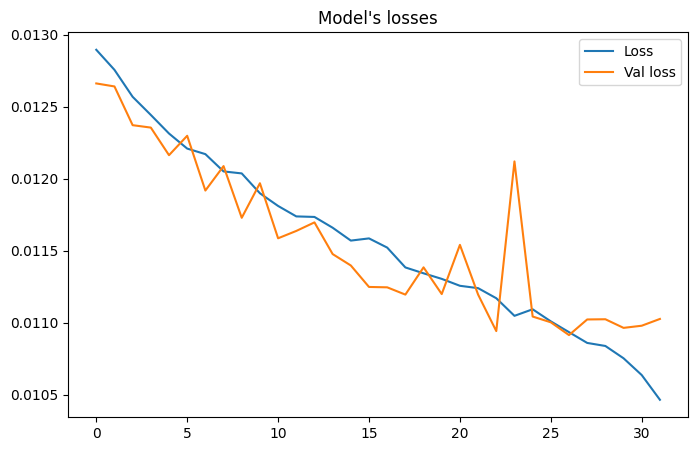

In [11]:
# visualize the losses of the model
loss =  history.history.get('loss')
val_loss = history.history.get('val_loss')

plt.figure(figsize=(8, 5))

plt.title('Model\'s losses')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Loss', 'Val loss'])
plt.show()

In [14]:
# do prediction on the test set: used for data visualization bellow
preds = colorize(autoencoder, X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


<ipython-input-6-52439b3072a5>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-6-52439b3072a5>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-6-52439b3072a5>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])


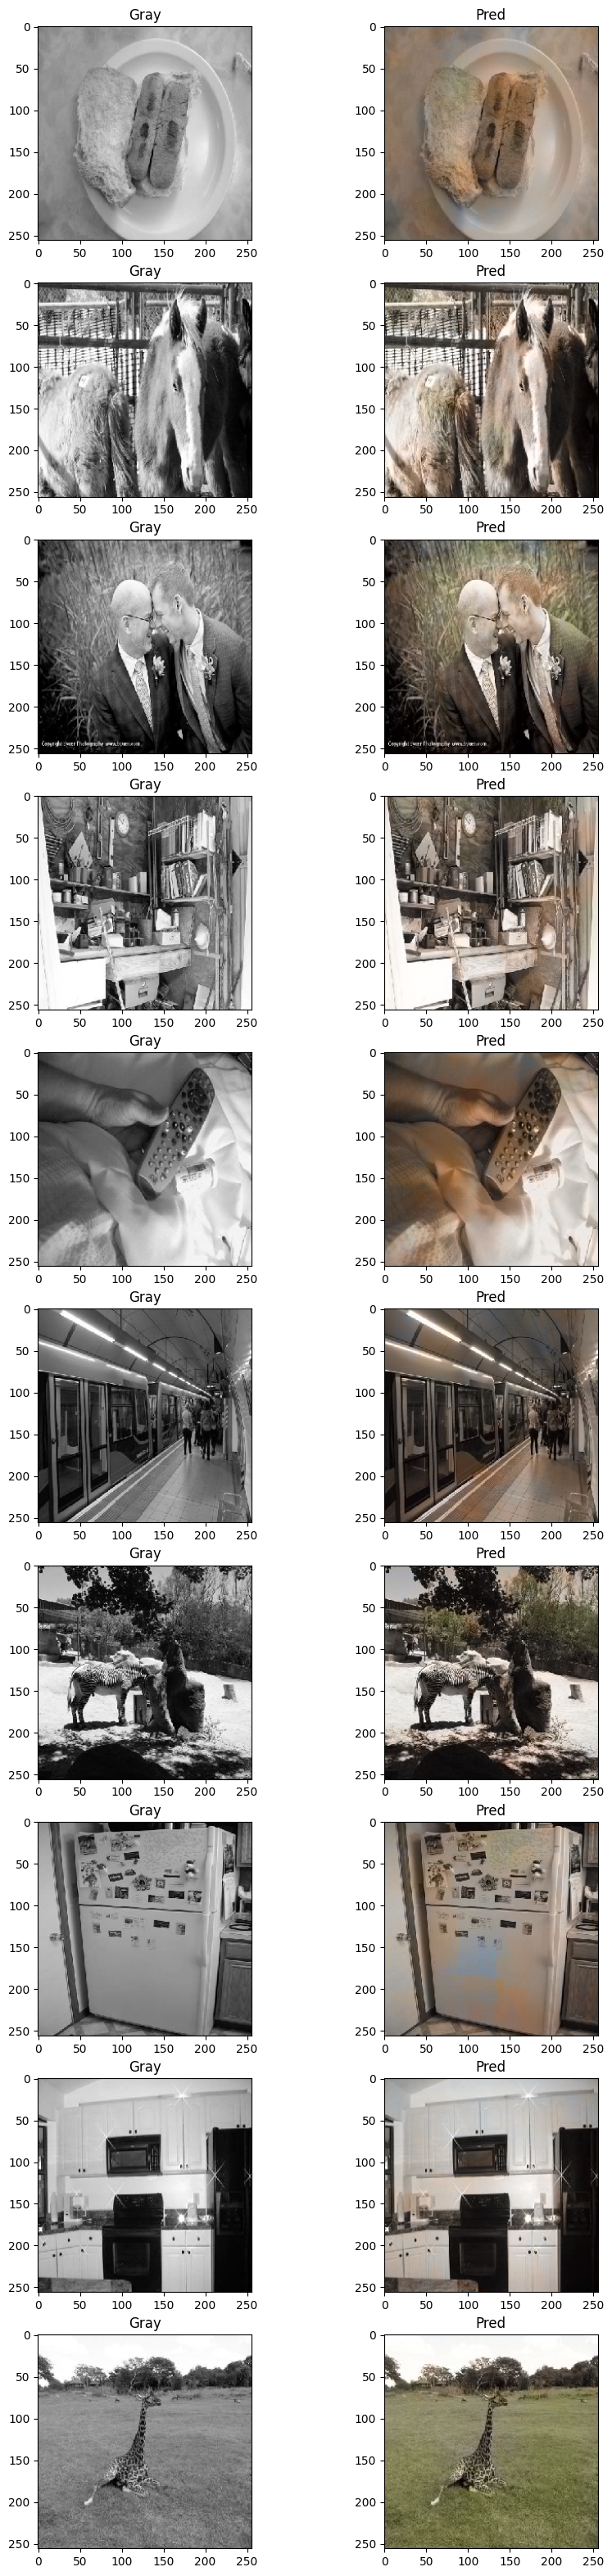

In [15]:
# visualize some results from the test set.
plt.figure(figsize=(10, 40))
s, e = 8, 18
index = 1
for i, j in zip(X_test[s:e], preds[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i, cmap='gray')
    plt.title('Gray')

    plt.subplot(10, 2, index+1)
    plt.imshow(j)
    plt.title('Pred')
    index += 2

In [20]:
# save the model
autoencoder.save('./img-colorization-model.keras')

In [21]:
# zip the model
!zip -r img-colorization-model.zip img-colorization-model

	zip warning: name not matched: img-colorization-model

zip error: Nothing to do! (try: zip -r img-colorization-model.zip . -i img-colorization-model)


# Thank you:)